# **Assignment 2**, **dataset 2**


# Problem statement



### Loading the dataset

The PlantVillage dataset contains 54,304 images. The images span 14 crop species: Apple, Blueberry, Cherry, Corn, Grape, Orange, Peach, Bell Pepper, Potato, Raspberry, Soybean, Squash, Strawberry, Tomato. In containes images of 17 fungal diseases, 4 bacterial diseases, 2 mold (oomycete) diseases, 2 viral disease, and 1 disease caused by a mite. 12 crop species also have images of healthy leaves that are not visibly affected by a disease.

https://arxiv.org/pdf/1511.08060

https://github.com/gabrieldgf4/PlantVillage-Dataset

For this assignment, you will make a model that predicts whether an potato leaf comes from a healthy or unhealthy plant (binary classification). The healthy apple leaf images are in the `Potato___healthy` folder, while unhealthy apple leaf images are in `Potato___Early_blight` and `Potato___Late_blight`. You are allowed to use a pretrained model that you transfer to this problem, if you whish so. Keep in mind that the dataset is highly unbalanced (152 vs 1000 vs 1000) so make sure to augment the dataset to account for that.

In [1]:
!git clone https://github.com/gabrieldgf4/PlantVillage-Dataset.git


fatal: destination path 'PlantVillage-Dataset' already exists and is not an empty directory.


In [2]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, io
from torchvision.transforms import ToTensor, transforms
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
from torchvision import models
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc

from tqdm import tqdm

In [3]:
dataset_path = 'PlantVillage-Dataset/'
healthy_potato_path = os.path.join(dataset_path, 'Potato___Healthy')
early_blight_path = os.path.join(dataset_path, 'Potato___Early_blight')
late_blight_path = os.path.join(dataset_path, 'Potato___Late_blight')

In [4]:
datapath_category = {'Potato___Healthy': 'healthy', 'Potato___Early_blight': "unhealthy", 'Potato___Late_blight': "unhealthy"}

def load_data(dir_path):

    result_df = pd.DataFrame(columns=['image', 'label'])

    for category, label in datapath_category.items():
        current_path = os.path.join(dir_path, category)

        images = os.listdir(current_path)
        number_of_images = len(images)

        current_df = pd.DataFrame({
            'image': [os.path.join(current_path, img) for img in images],
            'label': [label] * number_of_images
        })

        result_df = pd.concat([result_df, current_df], ignore_index=True)

    return result_df

potatoes = load_data(dataset_path)

potatoes.head()

image    label
0  PlantVillage-Dataset/Potato___Healthy/bf2bffbb...  healthy
1  PlantVillage-Dataset/Potato___Healthy/61b05f0a...  healthy
2  PlantVillage-Dataset/Potato___Healthy/31a09d39...  healthy
3  PlantVillage-Dataset/Potato___Healthy/413bc2e9...  healthy
4  PlantVillage-Dataset/Potato___Healthy/f66af6c0...  healthy

## **Exploratory Data Analysis**

The student will have to make a written analysis of the data being loaded (depending on the dataset that was assigned to them). They should apply methods of inspecting the data and make some exploratory data analysis

### Information about the dataset

In [5]:
dataset_length = len(potatoes)
category_sum = potatoes['label'].value_counts()

print(f"Total number of images in the dataset: {dataset_length}")
print("Number of images per category:")
print(category_sum)
print()
print(f"Image shape: {io.read_image(potatoes['image'][0]).shape}")

Total number of images in the dataset: 2152
Number of images per category:
label
unhealthy    2000
healthy       152
Name: count, dtype: int64

Image shape: torch.Size([3, 256, 256])


### Show images of potato leaves

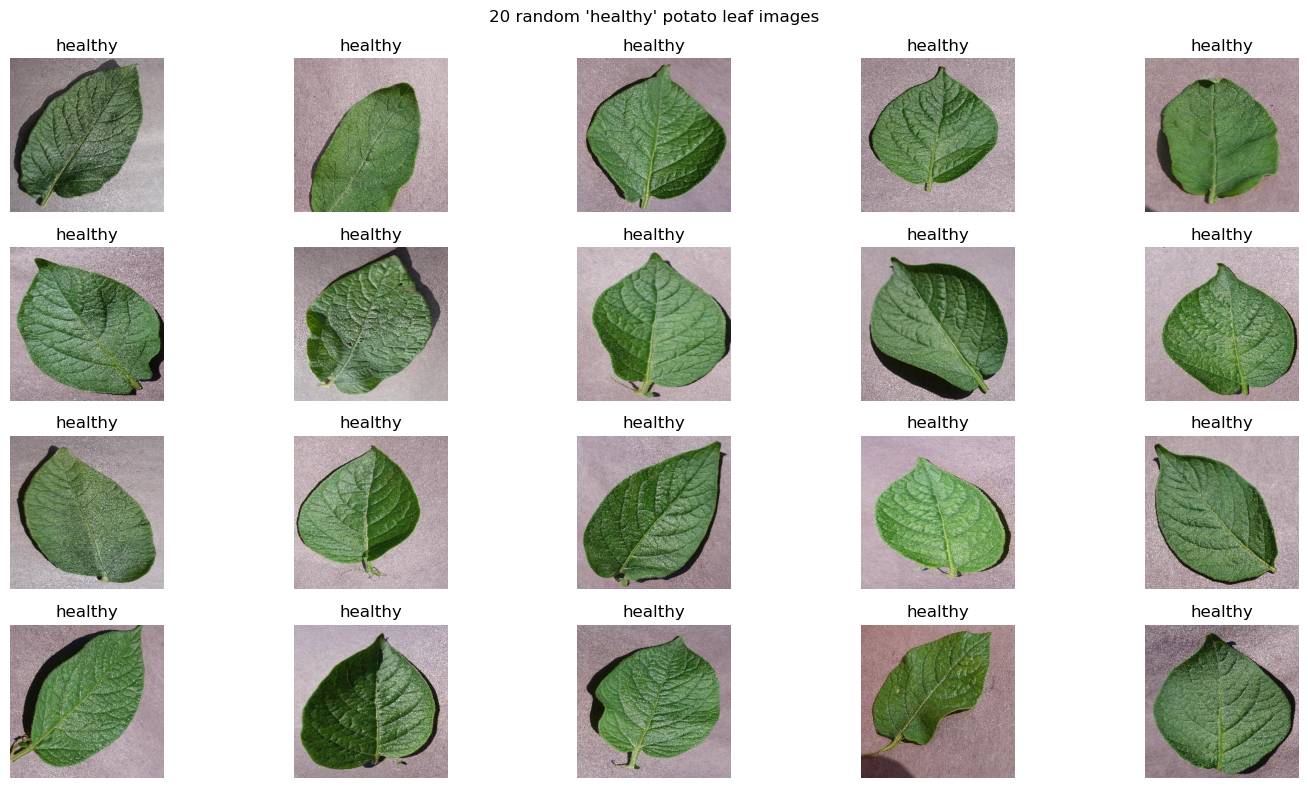

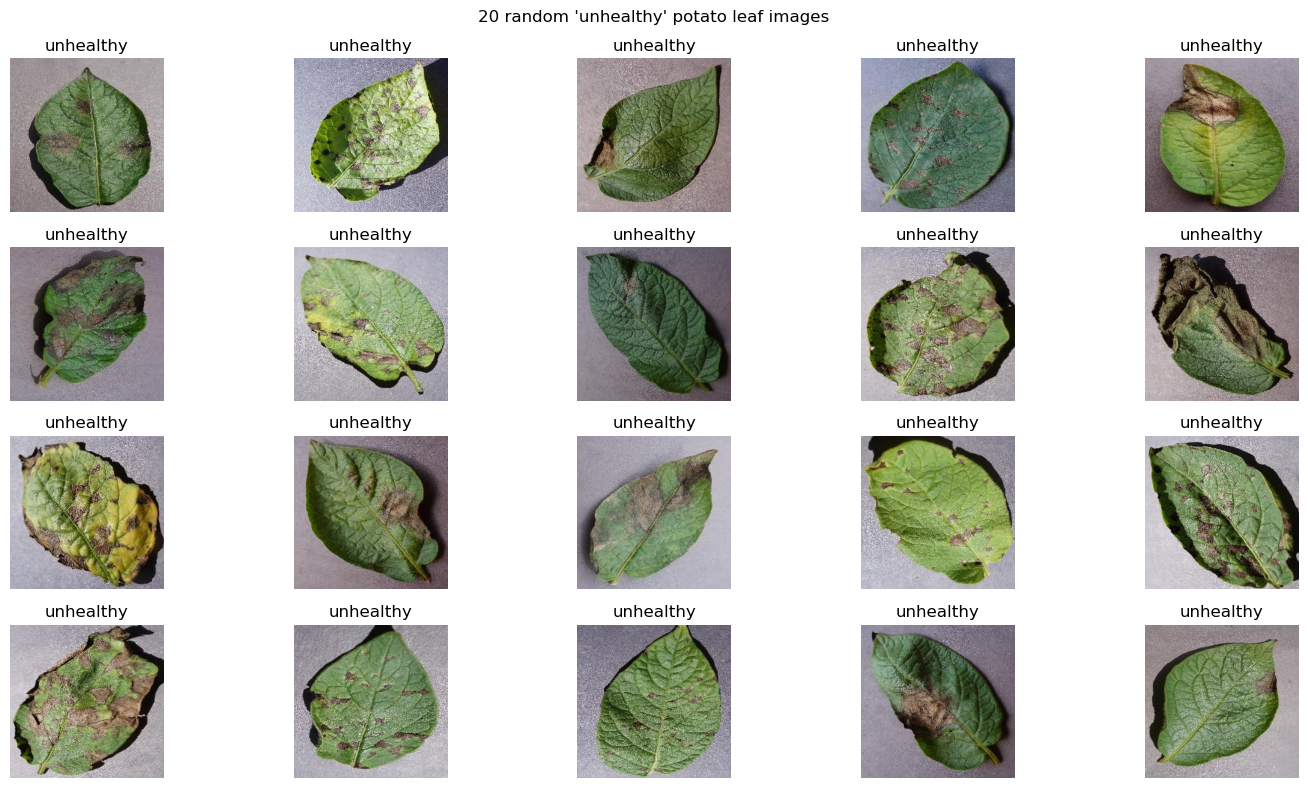

In [6]:
import random

def plot_potato_images(data, class_label, n=20, image_reader=None):
    """
    Plots n images of from the dataset given.
    
    Parameters:
    - data: List of image data
    - class_label: Label for the class of images to plot
    - n: Number of images to plot
    - image_reader: Function to read images, defaults to torchvision.io.read_image

    """
    plt.figure(figsize=(15, 8))
    for i, img_data in enumerate(data):

        img = img_data
        if image_reader is not None:
            img = image_reader(img_data)

        # Convert to HWC for matplotlib
        img = img.permute(1, 2, 0).numpy()
        plt.subplot(4, 5, i+1)
        plt.imshow(img.astype('uint8'))
        plt.axis('off')
        plt.title(class_label)
    plt.suptitle(f"{n} random '{class_label}' potato leaf images")
    plt.tight_layout()
    plt.show()

def plot_potato_images_from_dataframe(df, class_label, n=20):
    # Filter dataframe for the class
    class_df = df[df['label'] == class_label]
    # Randomly sample n images
    sample_df = class_df.sample(n=min(n, len(class_df)), random_state=42)

    plot_potato_images(sample_df['image'], class_label, n=n, image_reader=io.read_image)
    

# Plot 20 healthy and 20 unhealthy potato images
plot_potato_images_from_dataframe(potatoes, 'healthy', n=20)
plot_potato_images_from_dataframe(potatoes, 'unhealthy', n=20)

## **Data Preprocessing**:

If applicable, the student will create new features from existing data to improve model performance and/or select the most relevant features for the model.

## **Data Transformation**

The student should prepare the data for the training. Augmenting, splitting, and otherwise transforming should be done here.

### Implementing a dataloader

In [7]:
class PotatoDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transform_unhealthy=None, transform_healthy=None, transform_label=None):
        self.dataframe = dataframe
        self.transform_unhealthy = transform_unhealthy
        self.transform_healthy = transform_healthy
        self.transform_label = transform_label

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image']
        image = io.read_image(img_path)
        label = self.dataframe.iloc[idx]['label']

        if self.transform_unhealthy and label == 'unhealthy':
            image = self.transform_unhealthy(image)
        elif self.transform_healthy and label == 'healthy':
            image = self.transform_healthy(image)

        label_nr = 1 if label == 'healthy' else 0
        if self.transform_label:
            label_nr = self.transform_label(label_nr)

        return image, label_nr

    def get_column_idx(self, column_name):
        return self.dataframe.columns.get_loc(column_name)

### Create transforms

In [8]:
torch.manual_seed(42)

image_size = (224, 224)

# Transform to augment the images and convert them to float tensors
augmentation_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0)),
    transforms.Resize(image_size),
    transforms.ConvertImageDtype(torch.float)
])

# Transform to ensure size of the image and convert to float tensors
basic_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ConvertImageDtype(torch.float)
])

### Show example of augmented images from the minority class

Lenght of augmented dataset: 1976


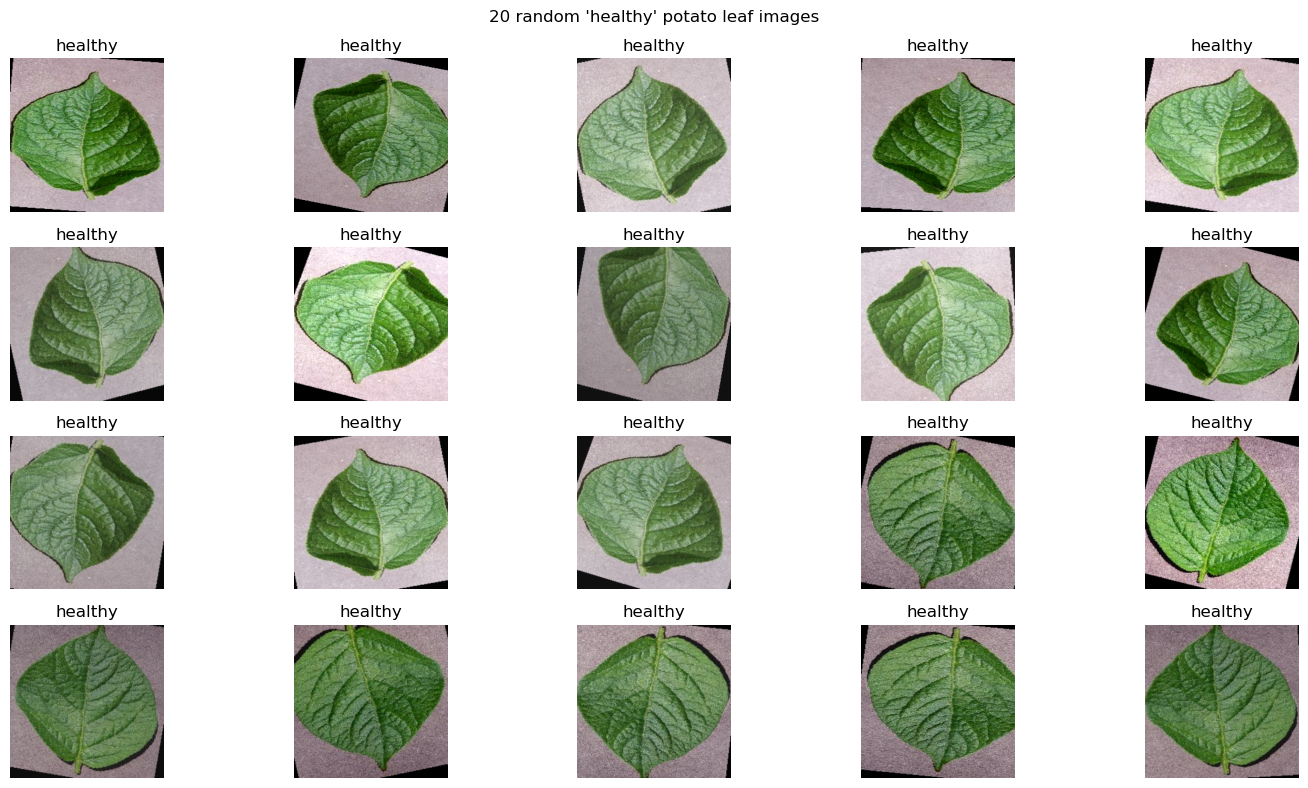

In [9]:
augmented_dataset = []

sampling_augmentation_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0)),
])

for idx, row in potatoes[potatoes['label'] == 'healthy'].iterrows():
    img_path = row['image']
    image = io.read_image(img_path)
    
    # Apply augmentation
    augmented_images = [sampling_augmentation_transform(image) for _ in range(13)]

    # Create new entries for the augmented images
    for aug_img in augmented_images:
        augmented_dataset.append((aug_img, row['label']))

print(f"Lenght of augmented dataset: {len(augmented_dataset)}")
plot_potato_images([img for img, _ in augmented_dataset[:20]], 'healthy', n=20)

## **Model Selection**


The student should implement a simple model as a baseline to compare more complex models. The student should try more complex modes and justify their rejection or acceptance.

In [10]:
X_train, X_test = train_test_split(potatoes, test_size=0.2, stratify=potatoes['label'], random_state=42)

print(f"Length of train: {len(X_train)}")
print(f"Length of test: {len(X_test)}")

Length of train: 1721
Length of test: 431


## Prepare training a model

### Creat training loop and use Stratified K-fold



What you will see here is a training loop modified to use the StratifiedKFold class, which splits the training set into k folds of train and validation sets. Since the augmentation only should happen for the training data in the fold, then the images of the minority class labels is augmented in the k-fold loop. The code for the training loop may seem a bit complex. However, the reason for that was to try and explore how the models perform when not doing anything with the data. For that reason the training loop function has the possibility to add a dataloader factory which can control how the datasets should be created.

Furthermore, since the dataset is imbalanced with the healthy class label being the minority class, I have added a WeightedRandomSampler to the data loader to ensure that the training data in the k-fold loop is being balanced. 

In [11]:
def create_weighted_sampler(dataset):
    """
    Create a weighted sampler for the dataset based on the class distribution.
    
    Parameters:
    - dataset: The dataset to create the sampler for
    - indices: The indices of the dataset to sample from
    
    Returns:
    - A WeightedRandomSampler instance
    """
    labels = dataset.dataframe['label'].apply(lambda x: 1 if x == 'healthy' else 0).values

    class_counts = np.bincount(labels)
    max_class_index = np.argmax(class_counts)

    class_weights = 1. / class_counts
    sample_weights = [class_weights[label] for label in labels]

    # Convert numpy scalar to Python int to avoid the error
    num_samples = int(class_counts[max_class_index])
    
    return WeightedRandomSampler(weights=sample_weights, num_samples=num_samples, replacement=True)

In [12]:
def create_dataloader(training_data, validation_data, batch_size=32, num_workers=0, sampler_factory=None):

    train_sampler = None
    should_shuffle = not sampler_factory

    training_dataset = PotatoDataset(
        dataframe=training_data,
        transform_healthy=augmentation_transform,
        transform_unhealthy=basic_transform
    )

    # Validation data should not be augmented or transformed other than resizing and converting to float
    validation_dataset = PotatoDataset(dataframe=validation_data,
        transform_healthy=basic_transform,
        transform_unhealthy=basic_transform
    )   

    if sampler_factory:
        train_sampler = sampler_factory(training_dataset)

    train_loader = DataLoader(
        training_dataset,
        batch_size=batch_size,
        shuffle=should_shuffle,
        num_workers=num_workers,
        sampler=train_sampler
    )

    validation_loader = DataLoader(
        validation_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
    )

    return train_loader, validation_loader

In [13]:
def training_loop(train_data, model, loss_func, optimizer, gpu=None, num_folds=5, num_epochs=10, folder="./output/", data_loader_factory=None, sampler_factory=None):
    kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

    epoch_stats = []
    train_labels = train_data['label'].values
    stats_path = os.path.join(folder, 'training_stats.json')
    min_valid_loss = np.inf

    initial_model_weight = model.state_dict()

    if not os.path.exists(folder):
        os.makedirs(folder)

    if not data_loader_factory:
        raise ValueError("data_loader_factory must be provided to create DataLoader instances.")

    # Register model to the GPU if available
    if gpu:
        model.to(gpu)

    for fold, (train_idx, val_idx) in enumerate(kf.split(train_data, train_labels)):
        print(f"-------- Training fold {fold + 1}/{num_folds} --------")

        # Create training and validation data for the current fold
        training_data, validation_data = train_data.iloc[train_idx], train_data.iloc[val_idx]

        # Create DataLoader instances for training and validation data (training dataloader may contain a sampler and additional transformations)
        X_training_data, X_validation_data = data_loader_factory(
            training_data,
            validation_data,
            sampler_factory=sampler_factory,
            batch_size=150
        )

        model.load_state_dict(initial_model_weight) # Reset model weights for each fold

        for epoch in range(num_epochs):

            epoch_train_loss = 0.0
            epoch_val_loss = 0.0

            # Batch train the model
            model.train()
            for images, labels in tqdm(X_training_data, desc=f"Training epoch {epoch+1}/{num_epochs}"):

                # Move images and labels to GPU if available
                if gpu:
                    images, labels = images.to(gpu), labels.to(gpu)
                
                output = model(images)
                loss = loss_func(output, labels)
                epoch_train_loss += loss.item()

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # Validate the model on the validation set
            model.eval()
            with torch.no_grad():
                for images, labels in tqdm(X_validation_data, desc=f"Validating epoch {epoch+1}/{num_epochs}"):
                    # Move images and labels to GPU if available
                    if gpu:
                        images, labels = images.to(gpu), labels.to(gpu)

                    output = model(images)
                    loss = loss_func(output, labels)
                    epoch_val_loss += loss.item()

            epoch_train_loss /= len(X_training_data)
            epoch_val_loss /= len(X_validation_data)

            print(f"Train loss: {epoch_train_loss}")
            print(f"Validation loss: {epoch_val_loss}")

            epoch_stats.append({'fold': fold + 1, 'epoch': epoch + 1, 'loss_train': epoch_train_loss, 'loss_valid': epoch_val_loss})

            # Save the model if validation loss has decreased  
            if min_valid_loss > epoch_val_loss:
                print(f'Validation Loss Decreased({min_valid_loss}--->{epoch_val_loss}) \t Saving The Model')
                min_valid_loss = epoch_val_loss
                # Saving State Dict
                torch.save(model.state_dict(), os.path.join(folder, 'saved_model.pth'))

        print(f"-------- End of Fold {fold + 1} --------")
    
    # Save the training stats to a JSON file
    with open(stats_path, 'w') as outfile:
        json.dump(
            epoch_stats, outfile,
        )

    return pd.read_json(stats_path)


### Create device to run training using hardware acceleration

In [14]:
gpu_device = None

if torch.cuda.is_available():
    gpu_device = torch.device("cuda")
    print("Using GPU: cuda")

if torch.backends.mps.is_available():
    gpu_device = torch.device("mps")
    print("Using GPU: mps")


Using GPU: mps


## Create and train a model

### Creating a simpel CNN model

In [15]:
# This model is based on the AlexNet architecture from the book "Hand-on Machine Learning with Scikit-Learn, Keras, and TensorFlow" by Aurélien Géron.

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),

            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.LeakyReLU(inplace=True),

            nn.Linear(4096, 2),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1) 
        x = self.classifier(x)
        return x
    

### Train model using stratified K-fold

In [16]:

def train_model(model, dataset: pd.DataFrame, learning_rate=0.001, num_epochs=10, gpu=None, output_dir="./output/", sampler_factory=None):

    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train model
    loss_df = training_loop(dataset, 
                            model=model, 
                            optimizer=optimizer,
                            loss_func=loss_function,
                            gpu=gpu_device, 
                            num_folds=5, 
                            num_epochs=num_epochs, 
                            folder=output_dir,
                            data_loader_factory=create_dataloader,
                            sampler_factory=sampler_factory)
    return model, loss_df


In [17]:

simple_model_sampled, simple_model_sampled_loss_df = train_model(CNN(), 
                                                   X_train, 
                                                   learning_rate=0.001, 
                                                   num_epochs=10, 
                                                   gpu=gpu_device, 
                                                   output_dir="./output/simple-cnn-sampled",
                                                   sampler_factory=create_weighted_sampler)


-------- Training fold 1/5 --------


Validating epoch 1/10: 100%|██████████| 3/3 [00:00<00:00,  3.49it/s]


Train loss: 0.8638675808906555
Validation loss: 0.6903291344642639
Validation Loss Decreased(inf--->0.6903291344642639) 	 Saving The Model


Validating epoch 2/10: 100%|██████████| 3/3 [00:00<00:00,  3.71it/s]


Train loss: 0.6936297549141778
Validation loss: 0.7002127170562744


Validating epoch 3/10: 100%|██████████| 3/3 [00:00<00:00,  3.84it/s]


Train loss: 0.6931234068340726
Validation loss: 0.7326800425847372


Validating epoch 4/10: 100%|██████████| 3/3 [00:00<00:00,  3.65it/s]


Train loss: 0.6515348156293234
Validation loss: 0.30548445383707684
Validation Loss Decreased(0.6903291344642639--->0.30548445383707684) 	 Saving The Model


Validating epoch 5/10: 100%|██████████| 3/3 [00:00<00:00,  3.84it/s]


Train loss: 0.7716386384434171
Validation loss: 0.7778369386990865


Validating epoch 6/10: 100%|██████████| 3/3 [00:00<00:00,  3.82it/s]


Train loss: 0.4707265827390883
Validation loss: 0.5957141518592834


Validating epoch 7/10: 100%|██████████| 3/3 [00:00<00:00,  3.81it/s]


Train loss: 0.42320092022418976
Validation loss: 0.2622244904438655
Validation Loss Decreased(0.30548445383707684--->0.2622244904438655) 	 Saving The Model


Validating epoch 8/10: 100%|██████████| 3/3 [00:00<00:00,  3.79it/s]


Train loss: 0.3054925815926658
Validation loss: 1.4810932477315266


Validating epoch 9/10: 100%|██████████| 3/3 [00:00<00:00,  3.86it/s]


Train loss: 0.530507183737225
Validation loss: 0.5682734052340189


Validating epoch 10/10: 100%|██████████| 3/3 [00:00<00:00,  3.80it/s]


Train loss: 0.5209752586152818
Validation loss: 0.6539863149325053
-------- End of Fold 1 --------
-------- Training fold 2/5 --------


Validating epoch 1/10: 100%|██████████| 3/3 [00:00<00:00,  3.70it/s]


Train loss: 0.8242672350671556
Validation loss: 0.6598352988560995


Validating epoch 2/10: 100%|██████████| 3/3 [00:00<00:00,  3.79it/s]


Train loss: 0.6939089761839973
Validation loss: 0.6958464781443278


Validating epoch 3/10: 100%|██████████| 3/3 [00:00<00:00,  3.85it/s]


Train loss: 0.6892581515842013
Validation loss: 0.24297880629698435
Validation Loss Decreased(0.2622244904438655--->0.24297880629698435) 	 Saving The Model


Validating epoch 4/10: 100%|██████████| 3/3 [00:00<00:00,  3.78it/s]


Train loss: 0.7573054499096341
Validation loss: 1.3647276957829793


Validating epoch 5/10: 100%|██████████| 3/3 [00:00<00:00,  3.82it/s]


Train loss: 0.7041382326020135
Validation loss: 0.6872768004735311


Validating epoch 6/10: 100%|██████████| 3/3 [00:00<00:00,  3.67it/s]


Train loss: 0.6913421154022217
Validation loss: 0.6104183594385783


Validating epoch 7/10: 100%|██████████| 3/3 [00:00<00:00,  3.84it/s]


Train loss: 0.6902649468845792
Validation loss: 0.6737558444341024


Validating epoch 8/10: 100%|██████████| 3/3 [00:00<00:00,  3.63it/s]


Train loss: 0.7216529846191406
Validation loss: 0.6633392771085104


Validating epoch 9/10: 100%|██████████| 3/3 [00:00<00:00,  3.74it/s]


Train loss: 0.5775928795337677
Validation loss: 0.2866532156864802


Validating epoch 10/10: 100%|██████████| 3/3 [00:00<00:00,  3.79it/s]


Train loss: 0.23423403004805246
Validation loss: 0.23944413661956787
Validation Loss Decreased(0.24297880629698435--->0.23944413661956787) 	 Saving The Model
-------- End of Fold 2 --------
-------- Training fold 3/5 --------


Validating epoch 1/10: 100%|██████████| 3/3 [00:00<00:00,  3.72it/s]


Train loss: 0.78607220782174
Validation loss: 0.9356256524721781


Validating epoch 2/10: 100%|██████████| 3/3 [00:00<00:00,  3.83it/s]


Train loss: 0.7014375925064087
Validation loss: 0.6874435345331827


Validating epoch 3/10: 100%|██████████| 3/3 [00:00<00:00,  3.76it/s]


Train loss: 0.6934531132380167
Validation loss: 0.6885634462038676


Validating epoch 4/10: 100%|██████████| 3/3 [00:00<00:00,  3.80it/s]


Train loss: 0.6930841538641188
Validation loss: 0.7072904904683431


Validating epoch 5/10: 100%|██████████| 3/3 [00:00<00:00,  3.77it/s]


Train loss: 0.6944546169704862
Validation loss: 0.7104873061180115


Validating epoch 6/10: 100%|██████████| 3/3 [00:00<00:00,  3.83it/s]


Train loss: 0.6931965019967821
Validation loss: 0.7003826300303141


Validating epoch 7/10: 100%|██████████| 3/3 [00:00<00:00,  3.88it/s]


Train loss: 0.6915508641137017
Validation loss: 0.6805952191352844


Validating epoch 8/10: 100%|██████████| 3/3 [00:00<00:00,  3.81it/s]


Train loss: 0.7420922120412191
Validation loss: 0.6791340112686157


Validating epoch 9/10: 100%|██████████| 3/3 [00:00<00:00,  3.77it/s]


Train loss: 0.6890848014089797
Validation loss: 0.6852136254310608


Validating epoch 10/10: 100%|██████████| 3/3 [00:00<00:00,  3.84it/s]


Train loss: 0.8852636019388834
Validation loss: 0.6801858941713969
-------- End of Fold 3 --------
-------- Training fold 4/5 --------


Validating epoch 1/10: 100%|██████████| 3/3 [00:00<00:00,  3.78it/s]


Train loss: 0.695392906665802
Validation loss: 0.693665087223053


Validating epoch 2/10: 100%|██████████| 3/3 [00:00<00:00,  3.74it/s]


Train loss: 6.016413927078247
Validation loss: 0.7523754040400187


Validating epoch 3/10: 100%|██████████| 3/3 [00:00<00:00,  3.82it/s]


Train loss: 0.7045104106267294
Validation loss: 0.6735366781552633


Validating epoch 4/10: 100%|██████████| 3/3 [00:00<00:00,  3.88it/s]


Train loss: 0.6934594379531013
Validation loss: 0.6710006395975748


Validating epoch 5/10: 100%|██████████| 3/3 [00:00<00:00,  3.89it/s]


Train loss: 0.6976165903939141
Validation loss: 0.6786246299743652


Validating epoch 6/10: 100%|██████████| 3/3 [00:00<00:00,  3.83it/s]


Train loss: 0.6921874350971646
Validation loss: 0.633726179599762


Validating epoch 7/10: 100%|██████████| 3/3 [00:00<00:00,  3.70it/s]


Train loss: 0.6959847211837769
Validation loss: 0.6936653653780619


Validating epoch 8/10: 100%|██████████| 3/3 [00:00<00:00,  3.81it/s]


Train loss: 0.6929314401414659
Validation loss: 0.6440281867980957


Validating epoch 9/10: 100%|██████████| 3/3 [00:00<00:00,  3.86it/s]


Train loss: 0.6948143310017056
Validation loss: 0.683533251285553


Validating epoch 10/10: 100%|██████████| 3/3 [00:00<00:00,  3.83it/s]


Train loss: 0.6933735013008118
Validation loss: 0.697242816289266
-------- End of Fold 4 --------
-------- Training fold 5/5 --------


Validating epoch 1/10: 100%|██████████| 3/3 [00:00<00:00,  3.89it/s]


Train loss: 0.7363990412818061
Validation loss: 0.4531303544839223


Validating epoch 2/10: 100%|██████████| 3/3 [00:00<00:00,  3.81it/s]


Train loss: 0.7033990489112006
Validation loss: 0.6890108982721964


Validating epoch 3/10: 100%|██████████| 3/3 [00:00<00:00,  3.81it/s]


Train loss: 0.7271068162388272
Validation loss: 0.7013037006060282


Validating epoch 4/10: 100%|██████████| 3/3 [00:00<00:00,  3.87it/s]


Train loss: 0.6925043265024821
Validation loss: 0.7922602494557699


Validating epoch 5/10: 100%|██████████| 3/3 [00:00<00:00,  3.84it/s]


Train loss: 0.6915276779068841
Validation loss: 0.7019970615704855


Validating epoch 6/10: 100%|██████████| 3/3 [00:00<00:00,  3.86it/s]


Train loss: 0.7701644831233554
Validation loss: 0.6949571172396342


Validating epoch 7/10: 100%|██████████| 3/3 [00:00<00:00,  3.83it/s]


Train loss: 0.6911424862013923
Validation loss: 0.6735554536183676


Validating epoch 8/10: 100%|██████████| 3/3 [00:00<00:00,  3.81it/s]


Train loss: 0.6946555773417155
Validation loss: 0.7030991911888123


Validating epoch 9/10: 100%|██████████| 3/3 [00:00<00:00,  3.86it/s]


Train loss: 0.6714382237858243
Validation loss: 0.7060075600941976


Validating epoch 10/10: 100%|██████████| 3/3 [00:00<00:00,  3.82it/s]

Train loss: 0.6950839426782396
Validation loss: 0.7623816927274069
-------- End of Fold 5 --------


### Transfer Learning on pre-trained model

We try to do transfer learning on ResNet18 and ResNet152(a larger model)

In [18]:
from torchvision import models
import torch.nn as nn

resnet_example = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V2)
print(f"Model architecture: {resnet_example}")

Model architecture: ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size

In [19]:
# ResNet-18 CNN
class CustomResnetSmall(nn.Module):
    def __init__(self):
        super(CustomResnetSmall, self).__init__()
        resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        
        for param in resnet.parameters():
            param.requires_grad = False

        custom_head = nn.Sequential(
            nn.Linear(resnet.fc.in_features, 256), 
            nn.ReLU(),
            nn.Linear(256, 2)
        )

        self.custom_resnet = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            resnet.maxpool,
            resnet.layer1,
            resnet.layer2,
            resnet.layer3,
            resnet.layer4,
            resnet.avgpool,
            nn.Flatten(),
            custom_head
        )
        
    def forward(self, x):
        return self.custom_resnet(x)

# ResNet-152 CNN
class CustomResnet(nn.Module):
    def __init__(self):
        super(CustomResnet, self).__init__()
        resnet = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V2)
        for param in resnet.parameters():
            param.requires_grad = False

        custom_head = nn.Sequential(
            nn.Linear(resnet.fc.in_features, 256), 
            nn.ReLU(),
            nn.Linear(256, 2)
        )

        self.custom_resnet = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            resnet.maxpool,
            resnet.layer1,
            resnet.layer2,
            resnet.layer3,
            resnet.layer4,
            resnet.avgpool,
            nn.Flatten(),
            custom_head
        )

    def forward(self, x):
        return self.custom_resnet(x)
        

In [20]:
sampled_model_resnet, sampled_model_resnet_loss_df = train_model(CustomResnet(), 
                                                   X_train, 
                                                   learning_rate=0.001, 
                                                   num_epochs=10, 
                                                   gpu=gpu_device, 
                                                   output_dir="./output/resnet-large-sampled",
                                                   sampler_factory=create_weighted_sampler)

-------- Training fold 1/5 --------


Validating epoch 1/10: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


Train loss: 0.3643688178724713
Validation loss: 0.4658616582552592
Validation Loss Decreased(inf--->0.4658616582552592) 	 Saving The Model


Validating epoch 2/10: 100%|██████████| 3/3 [00:04<00:00,  1.46s/it]


Train loss: 0.08693182613286707
Validation loss: 0.21942012012004852
Validation Loss Decreased(0.4658616582552592--->0.21942012012004852) 	 Saving The Model


Validating epoch 3/10: 100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


Train loss: 0.040067838918831616
Validation loss: 0.11535987506310146
Validation Loss Decreased(0.21942012012004852--->0.11535987506310146) 	 Saving The Model


Validating epoch 4/10: 100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


Train loss: 0.025615201331675053
Validation loss: 0.08914917334914207
Validation Loss Decreased(0.11535987506310146--->0.08914917334914207) 	 Saving The Model


Validating epoch 5/10: 100%|██████████| 3/3 [00:04<00:00,  1.47s/it]


Train loss: 0.01832855979187621
Validation loss: 0.08063170065482457
Validation Loss Decreased(0.08914917334914207--->0.08063170065482457) 	 Saving The Model


Validating epoch 6/10: 100%|██████████| 3/3 [00:04<00:00,  1.46s/it]


Train loss: 0.011820533209376864
Validation loss: 0.08103357255458832


Validating epoch 7/10: 100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


Train loss: 0.01258702371786866
Validation loss: 0.07933214058478673
Validation Loss Decreased(0.08063170065482457--->0.07933214058478673) 	 Saving The Model


Validating epoch 8/10: 100%|██████████| 3/3 [00:04<00:00,  1.46s/it]


Train loss: 0.012431612781559428
Validation loss: 0.07106933370232582
Validation Loss Decreased(0.07933214058478673--->0.07106933370232582) 	 Saving The Model


Validating epoch 9/10: 100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


Train loss: 0.013237604147030247
Validation loss: 0.05758338421583176
Validation Loss Decreased(0.07106933370232582--->0.05758338421583176) 	 Saving The Model


Validating epoch 10/10: 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


Train loss: 0.008932212885055277
Validation loss: 0.05925440415740013
-------- End of Fold 1 --------
-------- Training fold 2/5 --------


Validating epoch 1/10: 100%|██████████| 3/3 [00:04<00:00,  1.46s/it]


Train loss: 0.4127853545877669
Validation loss: 0.3955832322438558


Validating epoch 2/10: 100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


Train loss: 0.09287413251068857
Validation loss: 0.21547639866669974


Validating epoch 3/10: 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


Train loss: 0.03952051637073358
Validation loss: 0.1988003502289454


Validating epoch 4/10: 100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


Train loss: 0.021661429847073223
Validation loss: 0.07488534102837245


Validating epoch 5/10: 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


Train loss: 0.023636154054353636
Validation loss: 0.06325987726449966


Validating epoch 6/10: 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


Train loss: 0.01643192121345136
Validation loss: 0.058330737675229706


Validating epoch 7/10: 100%|██████████| 3/3 [00:04<00:00,  1.47s/it]


Train loss: 0.017936580232344568
Validation loss: 0.07834554960330327


Validating epoch 8/10: 100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


Train loss: 0.014637463545012806
Validation loss: 0.05520869263758262
Validation Loss Decreased(0.05758338421583176--->0.05520869263758262) 	 Saving The Model


Validating epoch 9/10: 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


Train loss: 0.006428841346253951
Validation loss: 0.05560415548582872


Validating epoch 10/10: 100%|██████████| 3/3 [00:04<00:00,  1.46s/it]


Train loss: 0.006072510784077976
Validation loss: 0.0647027591864268
-------- End of Fold 2 --------
-------- Training fold 3/5 --------


Validating epoch 1/10: 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


Train loss: 0.40563548770215774
Validation loss: 0.3486965397993724


Validating epoch 2/10: 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


Train loss: 0.07765803982814153
Validation loss: 0.13024075826009116


Validating epoch 3/10: 100%|██████████| 3/3 [00:04<00:00,  1.46s/it]


Train loss: 0.027873610560264852
Validation loss: 0.10366139560937881


Validating epoch 4/10: 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


Train loss: 0.029846694216960006
Validation loss: 0.16192588458458582


Validating epoch 5/10: 100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


Train loss: 0.01773297678058346
Validation loss: 0.04841666047771772
Validation Loss Decreased(0.05520869263758262--->0.04841666047771772) 	 Saving The Model


Validating epoch 6/10: 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


Train loss: 0.01947317564756506
Validation loss: 0.04232595985134443
Validation Loss Decreased(0.04841666047771772--->0.04232595985134443) 	 Saving The Model


Validating epoch 7/10: 100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


Train loss: 0.0122685050074425
Validation loss: 0.03841696803768476
Validation Loss Decreased(0.04232595985134443--->0.03841696803768476) 	 Saving The Model


Validating epoch 8/10: 100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


Train loss: 0.01602233866126173
Validation loss: 0.05054664487640063


Validating epoch 9/10: 100%|██████████| 3/3 [00:04<00:00,  1.48s/it]


Train loss: 0.01523062948965364
Validation loss: 0.029608707564572494
Validation Loss Decreased(0.03841696803768476--->0.029608707564572494) 	 Saving The Model


Validating epoch 10/10: 100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


Train loss: 0.004735505014347534
Validation loss: 0.03095246261606614
-------- End of Fold 3 --------
-------- Training fold 4/5 --------


Validating epoch 1/10: 100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


Train loss: 0.4151534338792165
Validation loss: 0.37387439608573914


Validating epoch 2/10: 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


Train loss: 0.07328910339209768
Validation loss: 0.18750726183255514


Validating epoch 3/10: 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


Train loss: 0.04539198542220725
Validation loss: 0.11026239146788915


Validating epoch 4/10: 100%|██████████| 3/3 [00:04<00:00,  1.43s/it]


Train loss: 0.027845078147947788
Validation loss: 0.0710066594183445


Validating epoch 5/10: 100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


Train loss: 0.022848354807744425
Validation loss: 0.06125623360276222


Validating epoch 6/10: 100%|██████████| 3/3 [00:04<00:00,  1.46s/it]


Train loss: 0.011542107444256544
Validation loss: 0.05668537442882856


Validating epoch 7/10: 100%|██████████| 3/3 [00:04<00:00,  1.46s/it]


Train loss: 0.008988646971475747
Validation loss: 0.061672127495209374


Validating epoch 8/10: 100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


Train loss: 0.006240949448612001
Validation loss: 0.053192321211099625


Validating epoch 9/10: 100%|██████████| 3/3 [00:04<00:00,  1.46s/it]


Train loss: 0.008129532500687573
Validation loss: 0.07661433890461922


Validating epoch 10/10: 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


Train loss: 0.00914884485407836
Validation loss: 0.053712104757626854
-------- End of Fold 4 --------
-------- Training fold 5/5 --------


Validating epoch 1/10: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


Train loss: 0.40748129453923965
Validation loss: 0.24173316359519958


Validating epoch 2/10: 100%|██████████| 3/3 [00:04<00:00,  1.48s/it]


Train loss: 0.08450523143013318
Validation loss: 0.13541331142187119


Validating epoch 3/10: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


Train loss: 0.05115026473585102
Validation loss: 0.14240502566099167


Validating epoch 4/10: 100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


Train loss: 0.03751151863899496
Validation loss: 0.13213740289211273


Validating epoch 5/10: 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


Train loss: 0.024459347491049103
Validation loss: 0.14668207615613937


Validating epoch 6/10: 100%|██████████| 3/3 [00:04<00:00,  1.43s/it]


Train loss: 0.023697850630722113
Validation loss: 0.13016536583503088


Validating epoch 7/10: 100%|██████████| 3/3 [00:04<00:00,  1.46s/it]


Train loss: 0.013359524464855591
Validation loss: 0.10018515959382057


Validating epoch 8/10: 100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


Train loss: 0.011364962931515442
Validation loss: 0.107608363032341


Validating epoch 9/10: 100%|██████████| 3/3 [00:04<00:00,  1.47s/it]


Train loss: 0.009714842670493655
Validation loss: 0.1155988269795974


Validating epoch 10/10: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]

Train loss: 0.003468167644718455
Validation loss: 0.0967881182829539
-------- End of Fold 5 --------


In [21]:
sampled_model_resnet_small, sampled_model_resnet_small_loss_df = train_model(CustomResnetSmall(), 
                                                   X_train, 
                                                   learning_rate=0.001, 
                                                   num_epochs=10, 
                                                   gpu=gpu_device, 
                                                   output_dir="./output/resnet-small-sampled",
                                                   sampler_factory=create_weighted_sampler)

-------- Training fold 1/5 --------


Validating epoch 1/10: 100%|██████████| 3/3 [00:00<00:00,  3.04it/s]


Train loss: 0.3370228012402852
Validation loss: 0.7931497891743978
Validation Loss Decreased(inf--->0.7931497891743978) 	 Saving The Model


Validating epoch 2/10: 100%|██████████| 3/3 [00:00<00:00,  3.30it/s]


Train loss: 0.06487843632284138
Validation loss: 0.1904252072175344
Validation Loss Decreased(0.7931497891743978--->0.1904252072175344) 	 Saving The Model


Validating epoch 3/10: 100%|██████████| 3/3 [00:00<00:00,  3.23it/s]


Train loss: 0.03262296256919702
Validation loss: 0.07599977528055508
Validation Loss Decreased(0.1904252072175344--->0.07599977528055508) 	 Saving The Model


Validating epoch 4/10: 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]


Train loss: 0.022621551011171605
Validation loss: 0.06593396390477817
Validation Loss Decreased(0.07599977528055508--->0.06593396390477817) 	 Saving The Model


Validating epoch 5/10: 100%|██████████| 3/3 [00:00<00:00,  3.15it/s]


Train loss: 0.016404765140679147
Validation loss: 0.05936437721053759
Validation Loss Decreased(0.06593396390477817--->0.05936437721053759) 	 Saving The Model


Validating epoch 6/10: 100%|██████████| 3/3 [00:00<00:00,  3.24it/s]


Train loss: 0.01926769693899486
Validation loss: 0.07961346224571268


Validating epoch 7/10: 100%|██████████| 3/3 [00:00<00:00,  3.07it/s]


Train loss: 0.026464230820743576
Validation loss: 0.06965025514364243


Validating epoch 8/10: 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]


Train loss: 0.012412644043150876
Validation loss: 0.05581828315431873
Validation Loss Decreased(0.05936437721053759--->0.05581828315431873) 	 Saving The Model


Validating epoch 9/10: 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]


Train loss: 0.012051444241984023
Validation loss: 0.05174782841155926
Validation Loss Decreased(0.05581828315431873--->0.05174782841155926) 	 Saving The Model


Validating epoch 10/10: 100%|██████████| 3/3 [00:00<00:00,  3.19it/s]


Train loss: 0.010872561018913984
Validation loss: 0.044547964818775654
Validation Loss Decreased(0.05174782841155926--->0.044547964818775654) 	 Saving The Model
-------- End of Fold 1 --------
-------- Training fold 2/5 --------


Validating epoch 1/10: 100%|██████████| 3/3 [00:00<00:00,  3.21it/s]


Train loss: 0.42121972143650055
Validation loss: 0.4940747022628784


Validating epoch 2/10: 100%|██████████| 3/3 [00:00<00:00,  3.23it/s]


Train loss: 0.09735359541243976
Validation loss: 0.2918652792771657


Validating epoch 3/10: 100%|██████████| 3/3 [00:00<00:00,  3.19it/s]


Train loss: 0.043120253417227
Validation loss: 0.05110728368163109


Validating epoch 4/10: 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]


Train loss: 0.03791505491567983
Validation loss: 0.03496641137947639
Validation Loss Decreased(0.044547964818775654--->0.03496641137947639) 	 Saving The Model


Validating epoch 5/10: 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]


Train loss: 0.015306569894568788
Validation loss: 0.0338259506970644
Validation Loss Decreased(0.03496641137947639--->0.0338259506970644) 	 Saving The Model


Validating epoch 6/10: 100%|██████████| 3/3 [00:00<00:00,  3.26it/s]


Train loss: 0.019999110476217337
Validation loss: 0.029799226361016434
Validation Loss Decreased(0.0338259506970644--->0.029799226361016434) 	 Saving The Model


Validating epoch 7/10: 100%|██████████| 3/3 [00:00<00:00,  3.31it/s]


Train loss: 0.014389216253120039
Validation loss: 0.055101433768868446


Validating epoch 8/10: 100%|██████████| 3/3 [00:00<00:00,  3.16it/s]


Train loss: 0.02044216959944202
Validation loss: 0.026653344742953777
Validation Loss Decreased(0.029799226361016434--->0.026653344742953777) 	 Saving The Model


Validating epoch 9/10: 100%|██████████| 3/3 [00:00<00:00,  3.15it/s]


Train loss: 0.014832284508479966
Validation loss: 0.03341271417836348


Validating epoch 10/10: 100%|██████████| 3/3 [00:00<00:00,  3.25it/s]


Train loss: 0.009605638320661254
Validation loss: 0.03037171997129917
-------- End of Fold 2 --------
-------- Training fold 3/5 --------


Validating epoch 1/10: 100%|██████████| 3/3 [00:00<00:00,  3.25it/s]


Train loss: 0.4224532726738188
Validation loss: 0.3589746654033661


Validating epoch 2/10: 100%|██████████| 3/3 [00:00<00:00,  3.25it/s]


Train loss: 0.07842959008283085
Validation loss: 0.0818132683634758


Validating epoch 3/10: 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]


Train loss: 0.03656630192158951
Validation loss: 0.047841839492321014


Validating epoch 4/10: 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]


Train loss: 0.021732133502761524
Validation loss: 0.06654800847172737


Validating epoch 5/10: 100%|██████████| 3/3 [00:00<00:00,  3.33it/s]


Train loss: 0.023200552600125473
Validation loss: 0.04702883710463842


Validating epoch 6/10: 100%|██████████| 3/3 [00:00<00:00,  3.19it/s]


Train loss: 0.019542629313137796
Validation loss: 0.0569650207956632


Validating epoch 7/10: 100%|██████████| 3/3 [00:00<00:00,  3.24it/s]


Train loss: 0.009241548496195011
Validation loss: 0.0417945459485054


Validating epoch 8/10: 100%|██████████| 3/3 [00:00<00:00,  3.24it/s]


Train loss: 0.0077743741114520365
Validation loss: 0.03528341961403688


Validating epoch 9/10: 100%|██████████| 3/3 [00:00<00:00,  3.24it/s]


Train loss: 0.01976520402563943
Validation loss: 0.035476118636627994


Validating epoch 10/10: 100%|██████████| 3/3 [00:00<00:00,  3.25it/s]


Train loss: 0.007063544019021922
Validation loss: 0.031093604862689972
-------- End of Fold 3 --------
-------- Training fold 4/5 --------


Validating epoch 1/10: 100%|██████████| 3/3 [00:00<00:00,  3.30it/s]


Train loss: 0.41369762851132286
Validation loss: 0.7122701605161031


Validating epoch 2/10: 100%|██████████| 3/3 [00:00<00:00,  3.25it/s]


Train loss: 0.07051091558403438
Validation loss: 0.39475183685620624


Validating epoch 3/10: 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]


Train loss: 0.052192996359533735
Validation loss: 0.2577233811219533


Validating epoch 4/10: 100%|██████████| 3/3 [00:00<00:00,  3.19it/s]


Train loss: 0.04837686139055424
Validation loss: 0.0686590460439523


Validating epoch 5/10: 100%|██████████| 3/3 [00:00<00:00,  3.25it/s]


Train loss: 0.017604521061811183
Validation loss: 0.01888818231721719
Validation Loss Decreased(0.026653344742953777--->0.01888818231721719) 	 Saving The Model


Validating epoch 6/10: 100%|██████████| 3/3 [00:00<00:00,  3.25it/s]


Train loss: 0.014322904766433768
Validation loss: 0.04706054584433635


Validating epoch 7/10: 100%|██████████| 3/3 [00:00<00:00,  3.22it/s]


Train loss: 0.008867526582131783
Validation loss: 0.015658032304296892
Validation Loss Decreased(0.01888818231721719--->0.015658032304296892) 	 Saving The Model


Validating epoch 8/10: 100%|██████████| 3/3 [00:00<00:00,  3.32it/s]


Train loss: 0.016869177627894614
Validation loss: 0.04163198762883743


Validating epoch 9/10: 100%|██████████| 3/3 [00:00<00:00,  3.31it/s]


Train loss: 0.006010997755866911
Validation loss: 0.020411566520730656


Validating epoch 10/10: 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]


Train loss: 0.014560886826883588
Validation loss: 0.06284577089051406
-------- End of Fold 4 --------
-------- Training fold 5/5 --------


Validating epoch 1/10: 100%|██████████| 3/3 [00:00<00:00,  3.21it/s]


Train loss: 0.41282769044240314
Validation loss: 0.9890970389048258


Validating epoch 2/10: 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]


Train loss: 0.0818271990865469
Validation loss: 0.1267769361535708


Validating epoch 3/10: 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]


Train loss: 0.025775183613101642
Validation loss: 0.1675463318824768


Validating epoch 4/10: 100%|██████████| 3/3 [00:00<00:00,  3.26it/s]


Train loss: 0.03434219508845773
Validation loss: 0.054121408611536026


Validating epoch 5/10: 100%|██████████| 3/3 [00:00<00:00,  3.26it/s]


Train loss: 0.020757550839334726
Validation loss: 0.02743568488707145


Validating epoch 6/10: 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]


Train loss: 0.009178401928188073
Validation loss: 0.01961370666200916


Validating epoch 7/10: 100%|██████████| 3/3 [00:00<00:00,  3.30it/s]


Train loss: 0.011300756596028805
Validation loss: 0.015917655158167083


Validating epoch 8/10: 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]


Train loss: 0.010344575262731977
Validation loss: 0.01450559108828505
Validation Loss Decreased(0.015658032304296892--->0.01450559108828505) 	 Saving The Model


Validating epoch 9/10: 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]


Train loss: 0.010853755093800524
Validation loss: 0.012637880475570759
Validation Loss Decreased(0.01450559108828505--->0.012637880475570759) 	 Saving The Model


Validating epoch 10/10: 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]


Train loss: 0.009413785378759107
Validation loss: 0.011669872949520746
Validation Loss Decreased(0.012637880475570759--->0.011669872949520746) 	 Saving The Model
-------- End of Fold 5 --------


### Show loss for each fold

----- Simple Model Training Loss -----


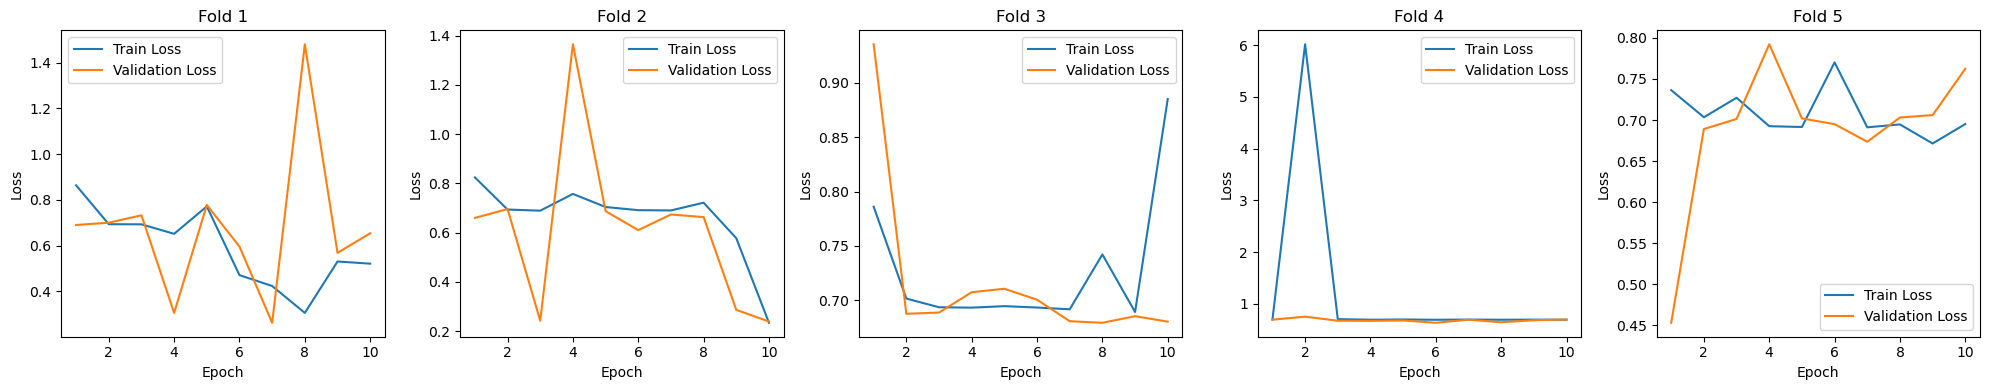

----- ResNet-18 Model Training Loss -----


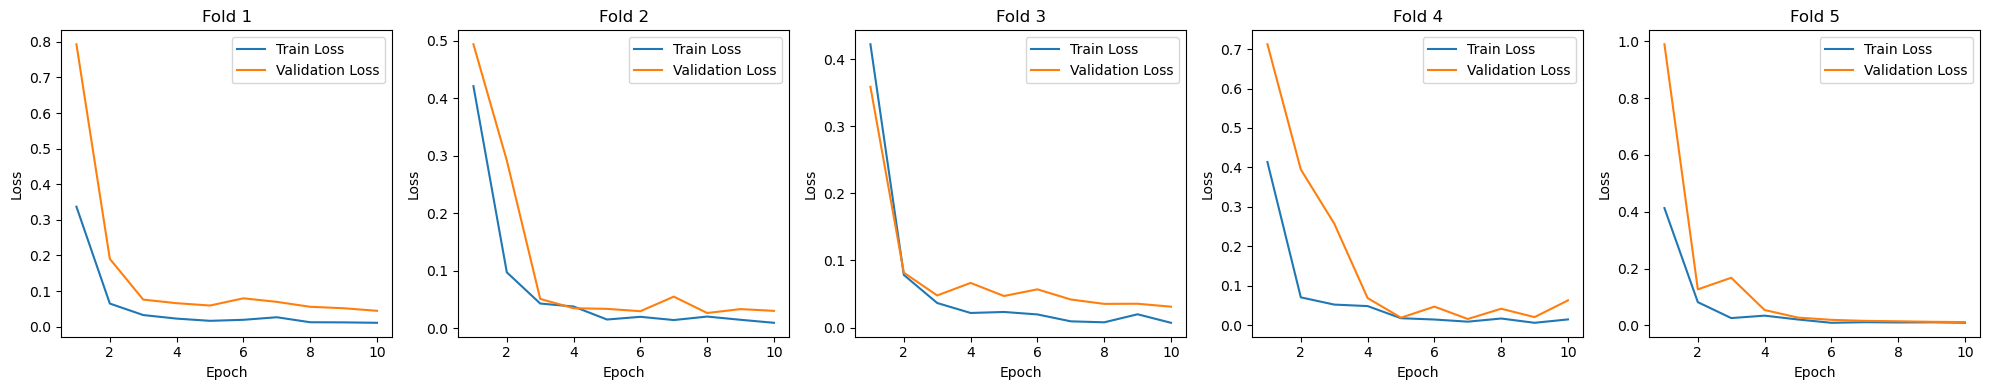

----- ResNet-152 Model Training Loss -----


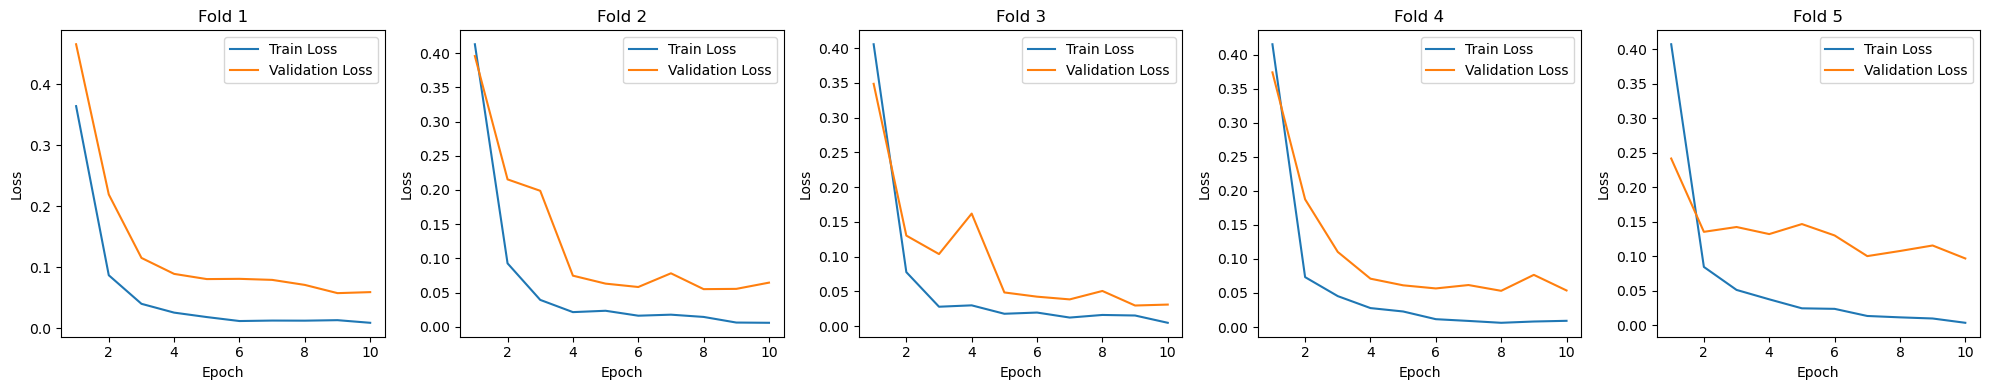

In [22]:
def evaluate_training(loss_df, title):
    """
    Evaluates the training by printing the length of the loss DataFrame and displaying the first few rows.
    """
    print(f"----- {title} -----")

    num_folds = loss_df['fold'].nunique()
    fig, axes = plt.subplots(1, num_folds, figsize=(4*num_folds, 4), sharey=False)

    for i, fold in enumerate(sorted(loss_df['fold'].unique())):
        fold_data = loss_df[loss_df['fold'] == fold]
        ax = axes[i] if num_folds > 1 else axes
        sns.lineplot(x='epoch', y='loss_train', data=fold_data, ax=ax, label='Train Loss')
        sns.lineplot(x='epoch', y='loss_valid', data=fold_data, ax=ax, label='Validation Loss')
        ax.set_title(f'Fold {fold}')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend()

    plt.tight_layout()
    plt.show()

evaluate_training(simple_model_sampled_loss_df, "Simple Model Training Loss")
evaluate_training(sampled_model_resnet_small_loss_df, "ResNet-18 Model Training Loss")
evaluate_training(sampled_model_resnet_loss_df, "ResNet-152 Model Training Loss")


## **Reporting the results**

The student should report the results. Identify which features are most influential in the model’s predictions, if applicable for the dataset and model used.

In [23]:
def get_model_predictions(model, loader, gpu=None):
    """
    Get predictions and probabilities from a model for ROC curve analysis
    """
    all_preds = []
    all_labels = []
    all_probs = []

    correct = 0

    model.eval()
    with torch.no_grad():
        for test_imgs, test_labels in loader:
            if gpu:
                test_imgs, test_labels = test_imgs.to(gpu), test_labels.to(gpu)

            output = model(test_imgs)

            # Get probabilities using softmax
            probs = F.softmax(output, dim=1)
            predicted = torch.max(output, 1)[1]

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(test_labels.cpu().numpy())
            # Get probability for positive class (healthy = 1)
            all_probs.extend(probs[:, 1].cpu().numpy())

            correct += (predicted == test_labels).sum()

            
    n = len(all_preds) 
    print("Test accuracy:{:.3f} ".format(float(correct) / (n)))
    print(f"Correct: {correct}/{n}")

    return np.array(all_labels), np.array(all_preds), np.array(all_probs)

def plot_roc_curves(models_data, title="ROC Curve Comparison"):
    """
    Plot ROC curves for multiple models
    
    models_data: list of tuples (model_name, y_true, y_probs)
    """
    plt.figure(figsize=(10, 8))
    
    for model_name, y_true, y_pred, y_probs in models_data:
        fpr, tpr, _ = roc_curve(y_true, y_probs)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, linewidth=2,
                     label=f'{model_name} (AUC = {roc_auc:.3f})')

    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend(loc="lower right", fontsize=10)
    plt.tight_layout()
    plt.show()


In [25]:
batch_size = 32
test_dataset = PotatoDataset(
    dataframe=X_test,
    transform_healthy=basic_transform,
    transform_unhealthy=basic_transform
)

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [26]:
# Load the best performing model weights
simple_model_sampled.load_state_dict(torch.load(os.path.join("./output/simple-cnn-sampled", 'saved_model.pth')))
sampled_model_resnet.load_state_dict(torch.load(os.path.join("./output/resnet-large-sampled", 'saved_model.pth')))
sampled_model_resnet_small.load_state_dict(torch.load(os.path.join("./output/resnet-small-sampled", 'saved_model.pth')))

# Predict on test data using the best performing model weights

# Simple CNN
print("Simple CNN model:")
y_true_simple, y_pred_simple, y_probs_simple = get_model_predictions(
    simple_model_sampled, test_dataloader, gpu_device
)
print("\n")

# ResNet-152
print("ResNet-152 model:")
y_true_resnet_large, y_pred_resnet_large, y_probs_resnet_large = get_model_predictions(
    sampled_model_resnet, test_dataloader, gpu_device
)
print("\n")

# ResNet-18
print("ResNet-18 model:")
y_true_resnet_small, y_pred_resnet_small, y_probs_resnet_small = get_model_predictions(
    sampled_model_resnet_small, test_dataloader, gpu_device
)
print("\n")
    
model_results = [
    ("Simple CNN", y_true_simple, y_pred_simple, y_probs_simple),
    ("ResNet-18", y_true_resnet_small, y_pred_resnet_small, y_probs_resnet_small),
    ("ResNet-152", y_true_resnet_large, y_pred_resnet_large, y_probs_resnet_large)
]


Simple CNN model:
Test accuracy:0.921 
Correct: 397/431


ResNet-152 model:
Test accuracy:0.979 
Correct: 422/431


ResNet-18 model:
Test accuracy:0.998 
Correct: 430/431




In [27]:
print("========== Classification Reports ==========")
for i, (model_name, y_true, y_pred, y_probs) in enumerate(model_results):
    print(f"Classification Report - {model_name}")
    print(classification_report(y_true, y_pred, target_names=['Unhealthy', 'Healthy'], zero_division=0.0))

========== Classification Reports ==========
Classification Report - Simple CNN
              precision    recall  f1-score   support

   Unhealthy       0.93      0.99      0.96       401
     Healthy       0.00      0.00      0.00        30

    accuracy                           0.92       431
   macro avg       0.46      0.50      0.48       431
weighted avg       0.87      0.92      0.89       431

Classification Report - ResNet-18
              precision    recall  f1-score   support

   Unhealthy       1.00      1.00      1.00       401
     Healthy       1.00      0.97      0.98        30

    accuracy                           1.00       431
   macro avg       1.00      0.98      0.99       431
weighted avg       1.00      1.00      1.00       431

Classification Report - ResNet-152
              precision    recall  f1-score   support

   Unhealthy       0.99      0.99      0.99       401
     Healthy       0.89      0.80      0.84        30

    accuracy                     

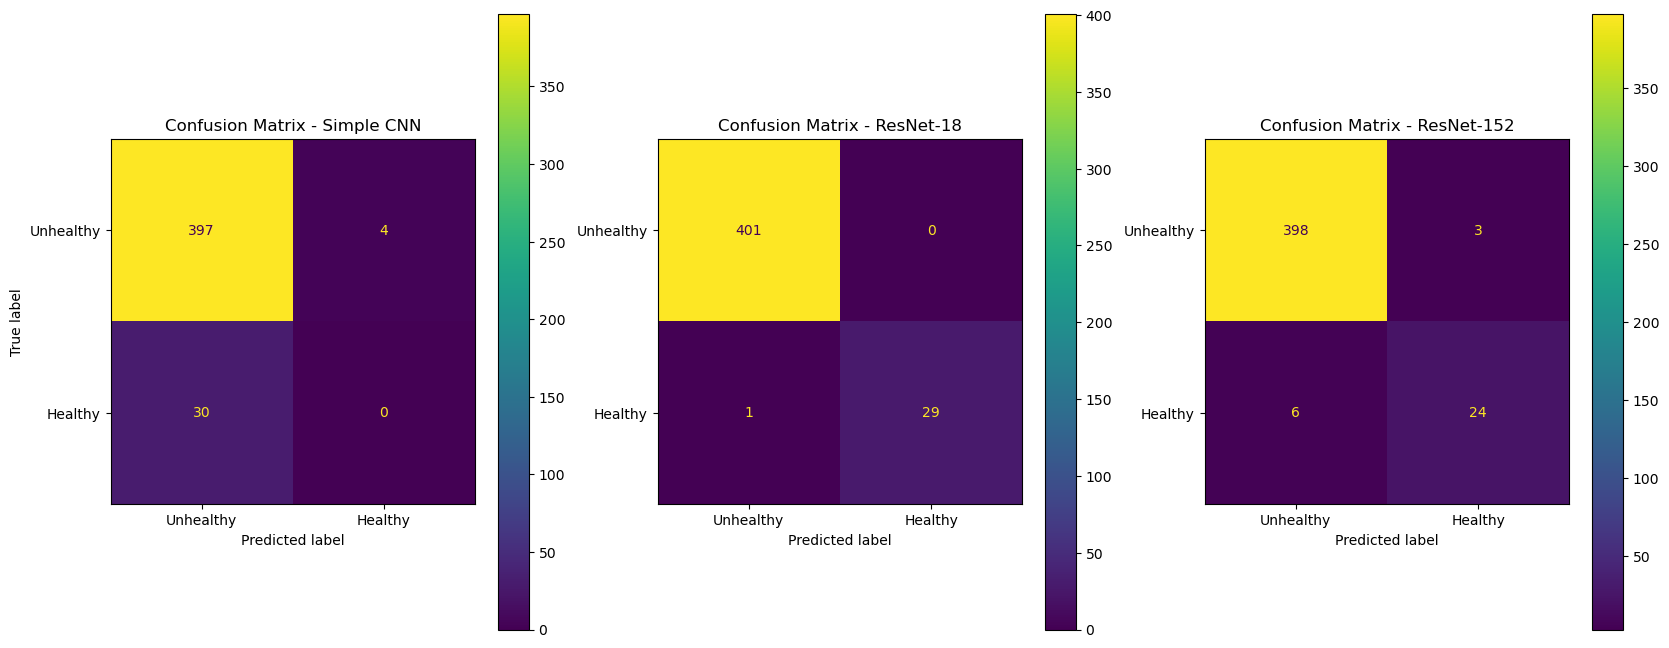

In [28]:
fig, axs = plt.subplots(1, 3, figsize=(20, 8))

# Compute confusion matrix
for i, (model_name, y_true, y_pred, y_probs) in enumerate(model_results):
    cm = confusion_matrix(y_true, y_pred)
    cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Unhealthy', 'Healthy'])
    cm_plot.plot(ax=axs[i])
    axs[i].set_title(f'Confusion Matrix - {model_name}')
        
    if not i == 0:
        axs[i].set_ylabel('')

plt.show()

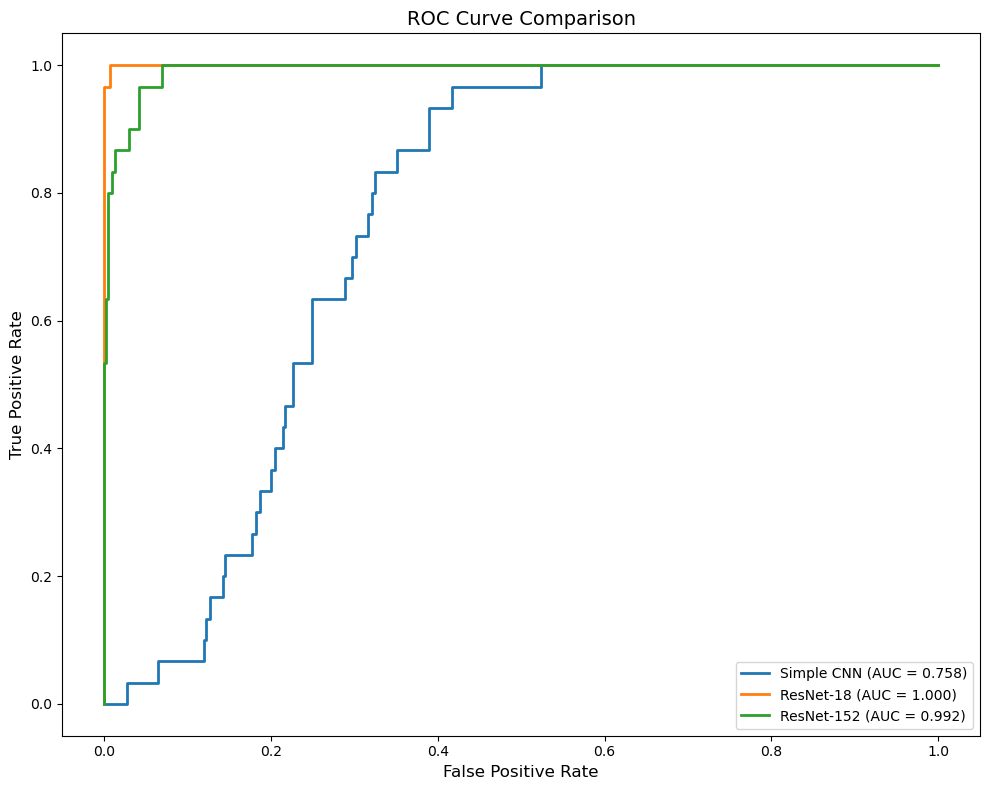

========= True/False Positive Rates ===========

Simple CNN:
  AUC: 0.7583
  Optimal Threshold: 0.0449
  TPR at optimal: 0.9667
  FPR at optimal: 0.4165

ResNet-18:
  AUC: 0.9998
  Optimal Threshold: 0.1590
  TPR at optimal: 1.0000
  FPR at optimal: 0.0075

ResNet-152:
  AUC: 0.9920
  Optimal Threshold: 0.0406
  TPR at optimal: 1.0000
  FPR at optimal: 0.0698


In [29]:
# Plot ROC curves
plot_roc_curves(model_results, "ROC Curve Comparison")

# Print detailed metrics
print("========= True/False Positive Rates ===========")

for model_name, y_true, y_pred, y_probs in model_results:
    fpr, tpr, thresholds = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    
    # Find optimal threshold (closest to top-left corner)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    
    print(f"\n{model_name}:")
    print(f"  AUC: {roc_auc:.4f}")
    print(f"  Optimal Threshold: {optimal_threshold:.4f}")
    print(f"  TPR at optimal: {tpr[optimal_idx]:.4f}")
    print(f"  FPR at optimal: {fpr[optimal_idx]:.4f}")

**Extra**: Any additional discussion and extra work relevant for solving the problem is welcome by the student and will contribute to a better grade.

# Summary

What I have done is the following:

## Data Analysis

The quality of the images were good. However, the potato leaf dataset is imbalanced towards the class label `Unhealthy`. Furhtermore, the dataset is fairly small.

## Data Pre-processing and Augmentation

In order to train on a small imbalanced dataset is to oversample the minority class. What I have created in this step is to prepare the custom dataset class to load images from file and create pytorch transformers to augment the images. 

Just as an example I have created a function to display the augmented images.

How oversampling and augmentation of the images works together will be explained in the next section. 

Additionally, I split the data into a training dataset and test dataset. In the `train_test_split` function i specify the stratify parameter to ensure that we the distribution of class labels are preserved.

## Model Selection

In the model selection I prepare to train a model by creating a training loop, that uses the Stratified K-fold. Since we have a small dataset, we have been taught that using k-fold is a good way train and evaluate the model of different subsets of the training data. Furthermore, the stratified version makes sure that it takes the labels into account when splitting the folds. 

Now before training the model on the fold data, I wrap the data into in the class `PotatoDataset`. For the training data, the dataset will be instantiated with the augmentation transformer for the minority class. However, the evaluation data of the fold, will not have any data augmentation. Additionally, in order to balance the classes in the training dataset, I use the WeightedRandomSampler.

**Overview of what is done to the folds training and evaluation data**

| Data part for k fold |  Augmenting  |  Sampling  |
|--|   ---|---|
| Training data | Yes (for minority class only) |  Yes (To provide balance of the two classes while training)  |
| Evaluation data | Only resize and convert datatype | No |

By augmenting and sampling the data, we can create more variants of the same image, therefor balancing the training data for the fold.

**Models**

In this assignment, I have chosen to train three models. 

1. The AlexNet model as described in the course litterature
2. ResNet-18 pretrained model with Transfer learning
3. ResNet-152 pretrained model with transfer learning

**Train and evaluation loss**

As can be seen the different k-folds the AlexNet model I created, does not seem to have a nice loss curve. Especially plot for fold 1, 2, 3, and 5 shows that the models loss does consistently improve over time. 

Shifting the attention to the two pre-trained models, we see that all plots for all folds shows a more consistent improvement. Additionally some of the folds shows that the evaluation scores gets worse in the last training iterations compared to the training loss, which shows the model overfits the training data. 

Since we save the best model weights based the best evaluation score, overfit that some of the ResNet traning folds shows in the end is not a problem(i.e. early stopping).

## Reporting the results

The test data used in the evaluation of the model performance is not getting sampled or augmented by flipping, rotating, or being cropped. Like the evaluation data in each fold, the test data is being left untouched. This is to ensure a fair evaluation across all models on the original data.

To evaluate the models, I have generated the following:
- Classification report
- Confussion Matrix
- ROC Curve and AUC
- Showing the True Positive Rate(TPR) and False Positive Rate(FPR)

Focusing on the simple model(i.e. AlexNet) performance, see that it fails to predict any of the healthy leaves correctly. This shows a lower AUC score at 0.758 and a high FPR at around 0.40. Looking at the classification report of the simple model, we can see that even though it is bad at capturing the variance of the healthy leaf images, the accuracy is high. However, the reason that the simple model has a high accuracy is because the test dataset is skewed towards the `unhealthy` class, which it has predicted every time.   

However, both ResNet models shows promising results. Looking at the Classification report for both of them shows high accurracy together with high recall and precision. The two models does differ. Surprisingly the larger model ResNet-152 had more False positive and False negative predictions resulting a lower recall and precision compared the smaller ResNet-18. Looking at the ROC curves confirms the performance reported in the classification report and confussion matrix.

Out of the three models trained, ResNet-18 is the one I would choose the use to predict new images. This is based on the results presented, and the fact that it is a smaller model than ResNet-152 which has proven to be faster when predicting as well.




